# Project 1 - American Put Analysis using a Binomial Model

**Author:** Alex Zhang

**Date:** October 17, 2024


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

pd.set_option('expand_frame_repr', True)
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
pd.set_option('display.width', 180)

In [3]:
class BinomialModelAmericanPut:
    def __init__(self, S0, K, T, r, sigma, mu, N):
        self.S0 = S0    # Initial stock price
        self.K = K      # Strike price
        self.T = T      # Time to maturity
        self.r = r      # Risk-free rate
        self.sigma = sigma  # Volatility
        self.mu = mu    # Expected return
        self.N = N      # Number of steps

        self.dt = T / N  # Time step size
        self.u = np.exp(r * self.dt + sigma * np.sqrt(self.dt))  # Up factor
        self.d = np.exp(r * self.dt - sigma * np.sqrt(self.dt))  # Down factor

        # Risk-neutral probabilities
        self.p = (np.exp(r * self.dt) - self.d) / (self.u - self.d)
        self.q = 1 - self.p

        # Practical probabilities
        self.real_p = (1 + (self.mu - self.r - self.sigma ** 2 / 2) * np.sqrt(self.dt) / self.sigma) / 2
        self.real_q = 1 - self.real_p

        # In the trees below, the i stands for th time step and the j stands for the state
        # Initialize the option value tree and delta tree
        self.option_values = np.full((N + 1, N + 1), np.nan)
        self.delta_values = np.full((N + 1, N), np.nan)
        # Initialize the exercise status tree
        self.exercise_status = np.full((N + 1, N), np.nan)
        self.realized_exercise = np.full((N + 1, N), np.nan)
        # Initialize the stock price tree
        self.stock_prices = np.full((N + 1, N + 1), np.nan)
        self._build_stock_price_tree()

        # Calculate option values using backward induction
        self._calculate_option_values()

    def _build_stock_price_tree(self):
        # Build the stock price tree
        # For each cell in the triangular matrix, (i - j) is the multiple of Up's and (j) is the multiple of Down's
        for i in range(self.N + 1):
            for j in range(i + 1):
                self.stock_prices[j, i] = self.S0 * (self.u ** (i - j)) * (self.d ** j)

    def _calculate_option_values(self):
        # Initialize the option values at maturity
        for j in range(self.N + 1):
            self.option_values[j, self.N] = max(0, self.K - self.stock_prices[j, self.N])

        # Backward induction to calculate option values and deltas
        for i in range(self.N - 1, -1, -1):
            for j in range(i + 1):
                # Calculate the value if we hold the option
                hold_value = np.exp(-self.r * self.dt) * (self.p * self.option_values[j, i + 1] +
                                                          self.q * self.option_values[j + 1, i + 1])
                # Calculate the value if we exercise the option
                exercise_value = self.K - self.stock_prices[j, i]

                # Determine the exercise status for this step
                if exercise_value >= hold_value:
                    self.exercise_status[j, i] = 0
                    self.option_values[j, i] = exercise_value
                else:
                    self.exercise_status[j, i] = 1
                    self.option_values[j, i] = hold_value

                # Calculate the delta
                self.delta_values[j, i] = (self.option_values[j, i + 1] - self.option_values[j + 1, i + 1]) / (
                    self.stock_prices[j, i + 1] - self.stock_prices[j + 1, i + 1])

        self.realized_exercise = self.exercise_status

    def get_early_exercise_prices(self):
        """
        Returns the stock prices at time step `t` where early exercise is optimal.
        """
        self.exercise_prices_js = np.nansum(self.exercise_status, axis=0).astype(int)
        self.exercise_prices = self.stock_prices[self.exercise_prices_js, np.arange(len(self.exercise_prices_js))]
        return self.exercise_prices_js, self.exercise_prices

    def fetch_along_the_path(self, path):
        """
        Given a path (a list of 1s and 0s, 1 for a Down and 0 for an Up), return the values we concern along the path.
        """
        js_path = np.insert(np.array(path), 0, 0).cumsum().astype(int)
        prices_path = self.stock_prices[js_path, np.arange(len(js_path))]
        # values_path = self.option_values[js_path, np.arange(len(js_path))]
        # exercise_path = self.exercise_status[js_path[:-1], np.arange(len(js_path)-1)]
        delta_path = self.delta_values[js_path[:-1], np.arange(len(js_path)-1)]
        return prices_path, delta_path

    def fetch_path_result(self, path):
        """
        Given a path (a list of 1s and 0s, 1 for a Down and 0 for an Up), return the PnL and stopping time of the path.
        """
        js_path = np.insert(np.array(path), 0, 0).cumsum().astype(int)
        exercise_path = self.realized_exercise[js_path[:-1], np.arange(len(js_path)-1)]
        if len(np.where(exercise_path == 0)[0]) > 0:
            stopping_time = np.where(exercise_path == 0)[0][0]
            PnL = self.K - self.stock_prices[js_path[stopping_time], stopping_time]
        else:
            stopping_time = len(js_path) - 1
            PnL = self.option_values[js_path[stopping_time], stopping_time]
        return PnL, stopping_time

    def gen_simulation_paths(self, num_paths):
        """
        Generate num_paths paths of the binomial tree.
        """
        return np.random.choice([0, 1], size=(num_paths, self.N), p=[self.real_q, self.real_p])

    def override_realized_exercise(self, exercise_boundary):
        first_constrain = np.where(~np.isnan(exercise_boundary))[0][0]
        for i in range(first_constrain):
            for j in range(i+1):
                self.realized_exercise[j, i] = 1
        self.realized_exercise[self.stock_prices[:,:-1] > exercise_boundary] = 1
        self.realized_exercise[self.stock_prices[:,:-1] <= exercise_boundary] = 0
        return self.realized_exercise


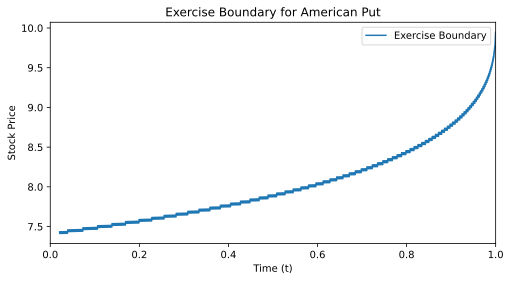

In [4]:
S0 = 10    # Initial stock price
K = 10     # Strike price
T = 1      # Time to maturity (1 year)
r = 0.02   # Risk-free rate
sigma = 0.20  # Volatility
mu = 0.05    # Expected return
N = 5000     # Number of steps

tree = BinomialModelAmericanPut(S0, K, T, r, sigma, mu, N)

early_exercise_js, exercise_boundary = tree.get_early_exercise_prices()
first_constrain = np.nonzero(early_exercise_js - np.arange(1,N+1))[0][0]

# i)
# Plot the exercise boundary as a function of t
times = np.linspace(0, T, N + 1)
plt.figure(figsize=(8, 4))
plt.plot(times, np.append(exercise_boundary, np.nan), label="Exercise Boundary")
plt.xlim(0, T)
plt.xlabel("Time (t)")
plt.ylabel("Stock Price")
plt.title("Exercise Boundary for American Put")
plt.legend();

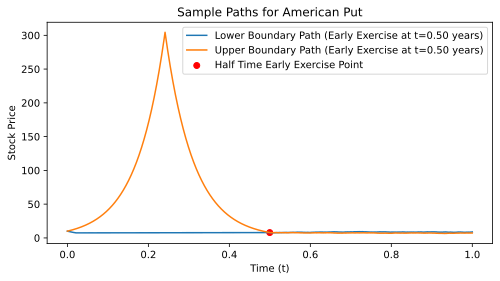

In [5]:
# ii)
# First generate the path where the option is exercised early near t = 1/2
# We need to check if it's possible to early exercise at int(N/2)
# Make sure that the boundary condition is not eliminated by former early exercises
t_half = int(N/2) - 1
while early_exercise_js[t_half] - early_exercise_js[t_half-1] == 1:
    t_half += 1
# First we find the lower boundary path for the option to be early exercised at t_half, the path after t_half is generated randomly
path_list_half_lower_bound = np.concatenate((np.diff(np.append(early_exercise_js[0:t_half]-1, early_exercise_js[t_half])), np.random.randint(0, 2, size=N-t_half))).astype(int)
prices_path_half_lower_bound, delta_path_half_lower_bound = tree.fetch_along_the_path(path_list_half_lower_bound)
# We can also find the upper boundary path for the option to be early exercised at t_half, the path after t_half is generated randomly
path_list_half_upper_bound = np.concatenate((np.zeros(t_half-early_exercise_js[t_half]), np.ones(early_exercise_js[t_half]), np.random.randint(0, 2, size=N-t_half))).astype(int)
prices_path_half_upper_bound, delta_path_half_upper_bound = tree.fetch_along_the_path(path_list_half_upper_bound)
# All the paths in between fits our requirement
plt.figure(figsize=(8, 4))
times = np.linspace(0, T, N + 1)
plt.plot(times, prices_path_half_lower_bound, label=f'Lower Boundary Path (Early Exercise at t={t_half/N*T:.2f} years)')
plt.plot(times, prices_path_half_upper_bound, label=f'Upper Boundary Path (Early Exercise at t={t_half/N*T:.2f} years)')
plt.scatter(t_half/N*T, prices_path_half_lower_bound[t_half], color='red',label = 'Half Time Early Exercise Point')
plt.xlabel("Time (t)")
plt.ylabel("Stock Price")
plt.title("Sample Paths for American Put")
plt.legend();

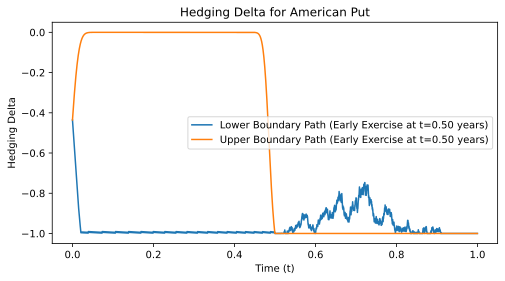

In [6]:
# iii)
plt.figure(figsize=(8, 4))
times = np.linspace(0, T, N + 1)
plt.plot(times, np.append(delta_path_half_lower_bound, np.nan), label=f'Lower Boundary Path (Early Exercise at t={t_half/N*T:.2f} years)')
plt.plot(times, np.append(delta_path_half_upper_bound, np.nan), label=f'Upper Boundary Path (Early Exercise at t={t_half/N*T:.2f} years)')
plt.xlabel("Time (t)")
plt.ylabel("Hedging Delta")
plt.title("Hedging Delta for American Put")
plt.legend();

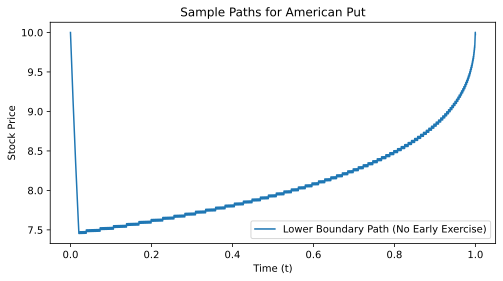

In [7]:
# Now generate the path where the option is not early exercised
t_full = N
# As the upper boundary path is trivial, we only look at the lower boundary path
path_list_full_lower_bound = np.append(np.diff(early_exercise_js[0:t_full+1]-1),1)
prices_path_full_lower_bound, delta_path_full_lower_bound = tree.fetch_along_the_path(path_list_full_lower_bound)
plt.figure(figsize=(8, 4))
times = np.linspace(0, T, N + 1)
plt.plot(times, prices_path_full_lower_bound, label='Lower Boundary Path (No Early Exercise)')
plt.xlabel("Time (t)")
plt.ylabel("Stock Price")
plt.title("Sample Paths for American Put")
plt.legend();

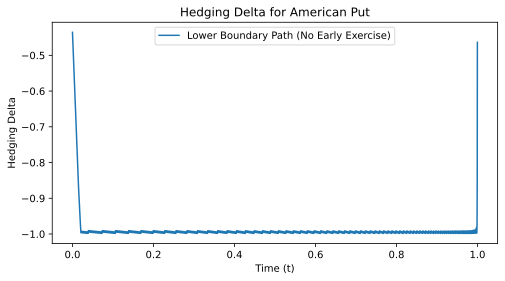

In [8]:
plt.figure(figsize=(8, 4))
times = np.linspace(0, T, N + 1)
plt.plot(times, np.append(delta_path_full_lower_bound, np.nan), label='Lower Boundary Path (No Early Exercise)')
plt.xlabel("Time (t)")
plt.ylabel("Hedging Delta")
plt.title("Hedging Delta for American Put")
plt.legend();

<Figure size 800x400 with 0 Axes>

(0.0, 1.0)

Text(0.5, 0, 'Time (t)')

Text(0, 0.5, 'Stock Price')

Text(0.5, 1.0, 'Exercise Boundary for American Put with sigma = 0.1; r = 0.0')

<Figure size 800x400 with 0 Axes>

Text(0.5, 0, 'Time (t)')

Text(0, 0.5, 'Stock Price')

Text(0.5, 1.0, 'Sample Paths for American Put with sigma = 0.1; r = 0.0')

<Figure size 800x400 with 0 Axes>

Text(0.5, 0, 'Time (t)')

Text(0, 0.5, 'Hedging Delta')

Text(0.5, 1.0, 'Hedging Delta for American Put with sigma = 0.1; r = 0.0')

<Figure size 800x400 with 0 Axes>

(0.0, 1.0)

Text(0.5, 0, 'Time (t)')

Text(0, 0.5, 'Stock Price')

Text(0.5, 1.0, 'Exercise Boundary for American Put with sigma = 0.1; r = 0.02')

<Figure size 800x400 with 0 Axes>

Text(0.5, 0, 'Time (t)')

Text(0, 0.5, 'Stock Price')

Text(0.5, 1.0, 'Sample Paths for American Put with sigma = 0.1; r = 0.02')

<Figure size 800x400 with 0 Axes>

Text(0.5, 0, 'Time (t)')

Text(0, 0.5, 'Hedging Delta')

Text(0.5, 1.0, 'Hedging Delta for American Put with sigma = 0.1; r = 0.02')

<Figure size 800x400 with 0 Axes>

(0.0, 1.0)

Text(0.5, 0, 'Time (t)')

Text(0, 0.5, 'Stock Price')

Text(0.5, 1.0, 'Exercise Boundary for American Put with sigma = 0.1; r = 0.04')

<Figure size 800x400 with 0 Axes>

Text(0.5, 0, 'Time (t)')

Text(0, 0.5, 'Stock Price')

Text(0.5, 1.0, 'Sample Paths for American Put with sigma = 0.1; r = 0.04')

<Figure size 800x400 with 0 Axes>

Text(0.5, 0, 'Time (t)')

Text(0, 0.5, 'Hedging Delta')

Text(0.5, 1.0, 'Hedging Delta for American Put with sigma = 0.1; r = 0.04')

<Figure size 800x400 with 0 Axes>

(0.0, 1.0)

Text(0.5, 0, 'Time (t)')

Text(0, 0.5, 'Stock Price')

Text(0.5, 1.0, 'Exercise Boundary for American Put with sigma = 0.2; r = 0.0')

<Figure size 800x400 with 0 Axes>

Text(0.5, 0, 'Time (t)')

Text(0, 0.5, 'Stock Price')

Text(0.5, 1.0, 'Sample Paths for American Put with sigma = 0.2; r = 0.0')

<Figure size 800x400 with 0 Axes>

Text(0.5, 0, 'Time (t)')

Text(0, 0.5, 'Hedging Delta')

Text(0.5, 1.0, 'Hedging Delta for American Put with sigma = 0.2; r = 0.0')

<Figure size 800x400 with 0 Axes>

(0.0, 1.0)

Text(0.5, 0, 'Time (t)')

Text(0, 0.5, 'Stock Price')

Text(0.5, 1.0, 'Exercise Boundary for American Put with sigma = 0.2; r = 0.02')

<Figure size 800x400 with 0 Axes>

Text(0.5, 0, 'Time (t)')

Text(0, 0.5, 'Stock Price')

Text(0.5, 1.0, 'Sample Paths for American Put with sigma = 0.2; r = 0.02')

<Figure size 800x400 with 0 Axes>

Text(0.5, 0, 'Time (t)')

Text(0, 0.5, 'Hedging Delta')

Text(0.5, 1.0, 'Hedging Delta for American Put with sigma = 0.2; r = 0.02')

<Figure size 800x400 with 0 Axes>

(0.0, 1.0)

Text(0.5, 0, 'Time (t)')

Text(0, 0.5, 'Stock Price')

Text(0.5, 1.0, 'Exercise Boundary for American Put with sigma = 0.2; r = 0.04')

<Figure size 800x400 with 0 Axes>

Text(0.5, 0, 'Time (t)')

Text(0, 0.5, 'Stock Price')

Text(0.5, 1.0, 'Sample Paths for American Put with sigma = 0.2; r = 0.04')

<Figure size 800x400 with 0 Axes>

Text(0.5, 0, 'Time (t)')

Text(0, 0.5, 'Hedging Delta')

Text(0.5, 1.0, 'Hedging Delta for American Put with sigma = 0.2; r = 0.04')

<Figure size 800x400 with 0 Axes>

(0.0, 1.0)

Text(0.5, 0, 'Time (t)')

Text(0, 0.5, 'Stock Price')

Text(0.5, 1.0, 'Exercise Boundary for American Put with sigma = 0.3; r = 0.0')

<Figure size 800x400 with 0 Axes>

Text(0.5, 0, 'Time (t)')

Text(0, 0.5, 'Stock Price')

Text(0.5, 1.0, 'Sample Paths for American Put with sigma = 0.3; r = 0.0')

<Figure size 800x400 with 0 Axes>

Text(0.5, 0, 'Time (t)')

Text(0, 0.5, 'Hedging Delta')

Text(0.5, 1.0, 'Hedging Delta for American Put with sigma = 0.3; r = 0.0')

<Figure size 800x400 with 0 Axes>

(0.0, 1.0)

Text(0.5, 0, 'Time (t)')

Text(0, 0.5, 'Stock Price')

Text(0.5, 1.0, 'Exercise Boundary for American Put with sigma = 0.3; r = 0.02')

<Figure size 800x400 with 0 Axes>

Text(0.5, 0, 'Time (t)')

Text(0, 0.5, 'Stock Price')

Text(0.5, 1.0, 'Sample Paths for American Put with sigma = 0.3; r = 0.02')

<Figure size 800x400 with 0 Axes>

Text(0.5, 0, 'Time (t)')

Text(0, 0.5, 'Hedging Delta')

Text(0.5, 1.0, 'Hedging Delta for American Put with sigma = 0.3; r = 0.02')

<Figure size 800x400 with 0 Axes>

(0.0, 1.0)

Text(0.5, 0, 'Time (t)')

Text(0, 0.5, 'Stock Price')

Text(0.5, 1.0, 'Exercise Boundary for American Put with sigma = 0.3; r = 0.04')

<Figure size 800x400 with 0 Axes>

Text(0.5, 0, 'Time (t)')

Text(0, 0.5, 'Stock Price')

Text(0.5, 1.0, 'Sample Paths for American Put with sigma = 0.3; r = 0.04')

<Figure size 800x400 with 0 Axes>

Text(0.5, 0, 'Time (t)')

Text(0, 0.5, 'Hedging Delta')

Text(0.5, 1.0, 'Hedging Delta for American Put with sigma = 0.3; r = 0.04')

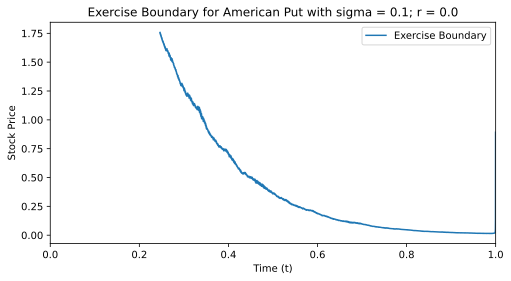

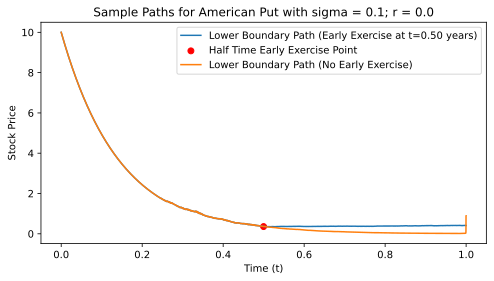

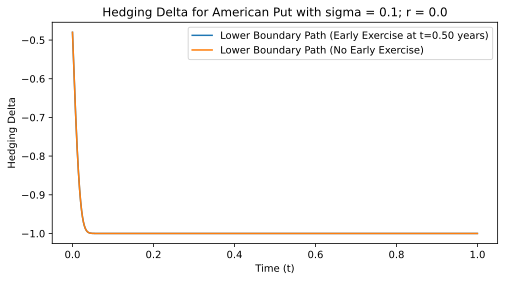

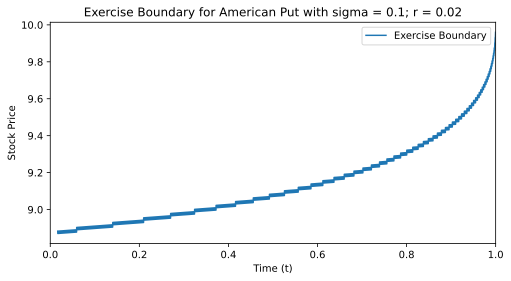

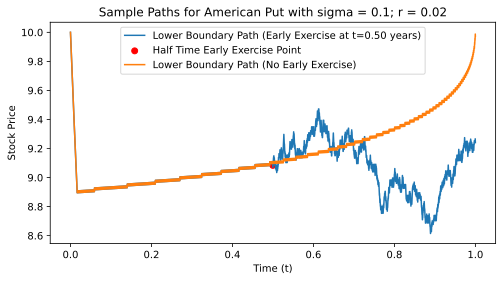

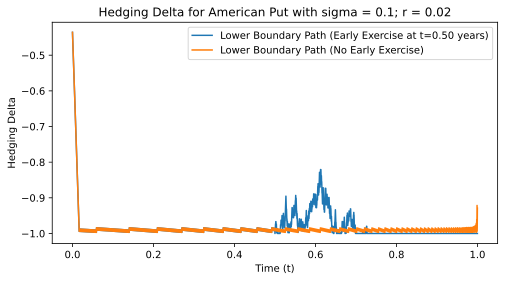

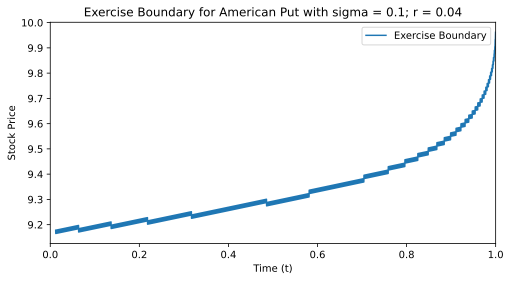

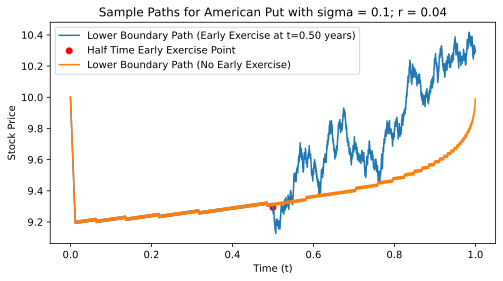

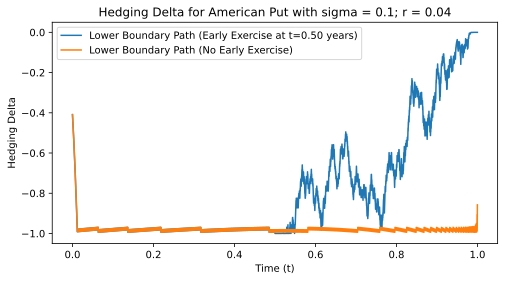

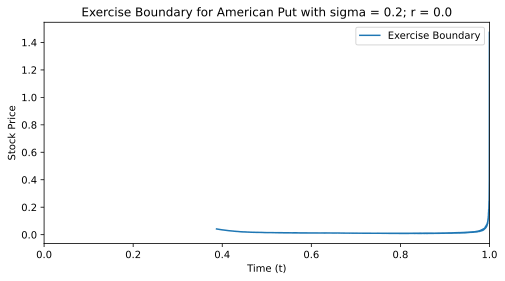

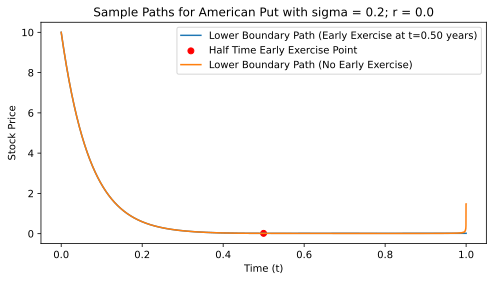

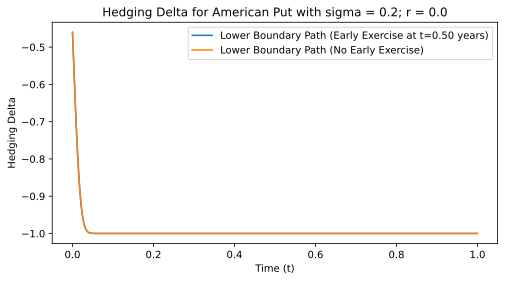

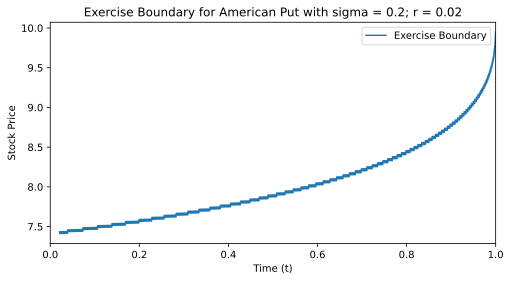

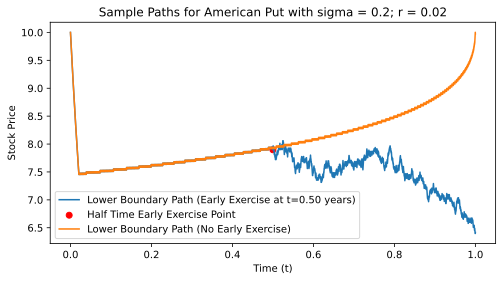

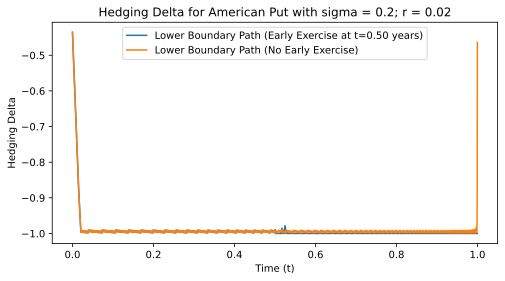

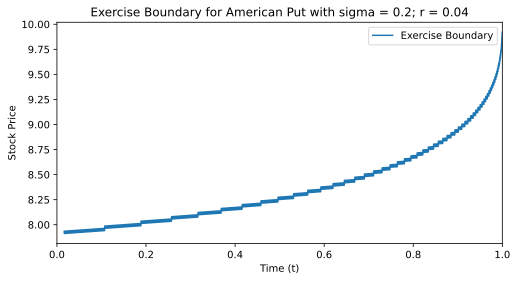

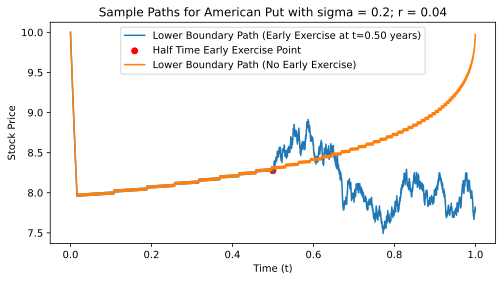

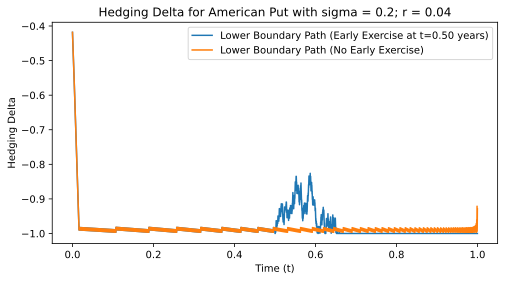

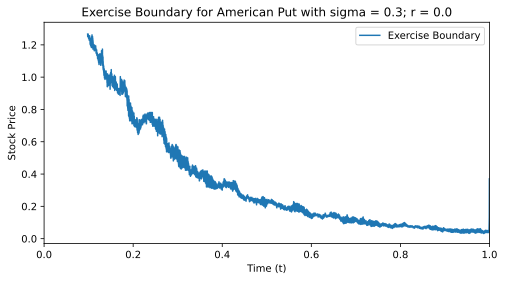

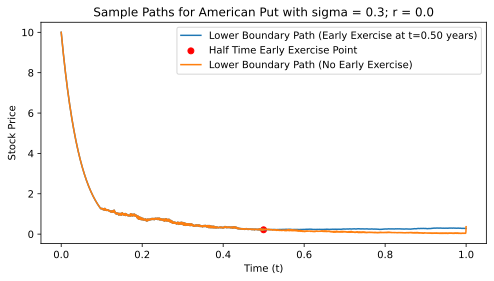

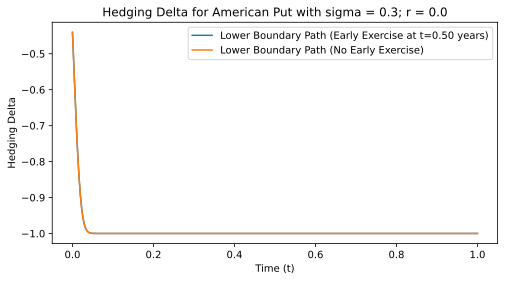

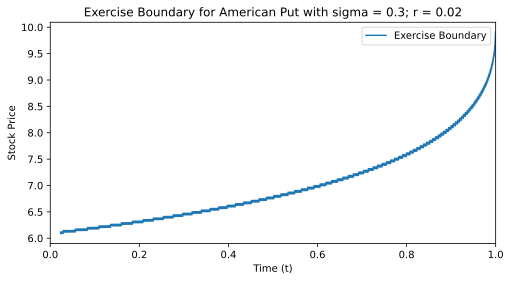

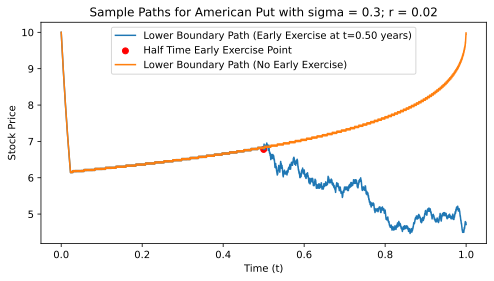

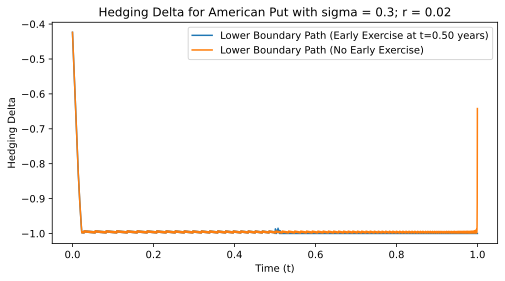

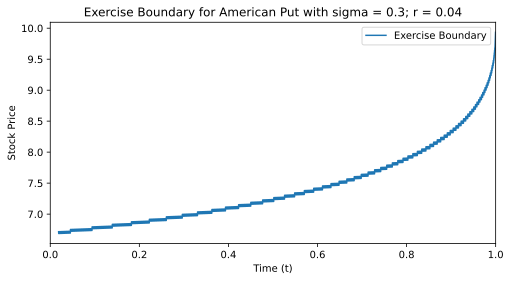

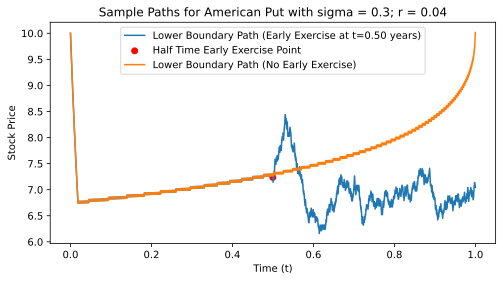

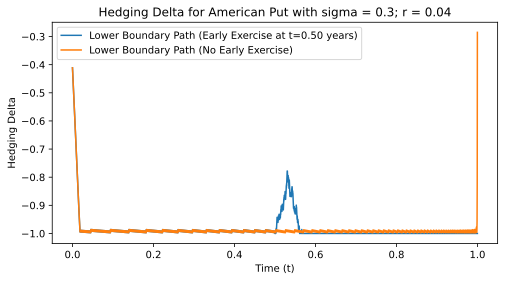

In [9]:
# iv)
for sigma_new in [0.10, 0.20, 0.30]:
    for r_new in [0.00, 0.02, 0.04]:
        tree = BinomialModelAmericanPut(S0, K, T, r_new, sigma_new, mu, N)
        early_exercise_js, exercise_boundary = tree.get_early_exercise_prices()
        # Plot the exercise boundary as a function of t
        times = np.linspace(0, T, N + 1)
        plt.figure(figsize=(8, 4))
        plt.plot(times, np.append(exercise_boundary, np.nan), label="Exercise Boundary")
        plt.xlim(0, T)
        plt.xlabel("Time (t)")
        plt.ylabel("Stock Price")
        plt.title(f"Exercise Boundary for American Put with sigma = {sigma_new}; r = {r_new}")
        plt.legend()
        # plt.savefig(f'/content/drive/My Drive/SyncWorkspace/MMF/MMF1928H/Project 1/Exercise_boundary_plot-sigma={sigma_new}&r={r_new}.jpg')

        # Generate the path where the option is exercised early near t = 1/2
        t_half = int(N/2) - 1
        while early_exercise_js[t_half] - early_exercise_js[t_half-1] == 1:
            t_half += 1
        path_list_half_lower_bound = np.concatenate((np.diff(np.append(early_exercise_js[0:t_half]-1, early_exercise_js[t_half])), np.random.randint(0, 2, size=N-t_half))).astype(int)
        prices_path_half_lower_bound, delta_path_half_lower_bound = tree.fetch_along_the_path(path_list_half_lower_bound)
        # Now generate the path where the option is not early exercised
        t_full = N
        path_list_full_lower_bound = np.append(np.diff(early_exercise_js[0:t_full+1]-1),1)
        prices_path_full_lower_bound, delta_path_full_lower_bound = tree.fetch_along_the_path(path_list_full_lower_bound)
        # Plot the price paths
        plt.figure(figsize=(8, 4))
        times = np.linspace(0, T, N + 1)
        plt.plot(times, prices_path_half_lower_bound, label=f'Lower Boundary Path (Early Exercise at t={t_half/N*T:.2f} years)')
        plt.scatter(t_half/N*T, prices_path_half_lower_bound[t_half], color='red',label = 'Half Time Early Exercise Point')
        plt.plot(times, prices_path_full_lower_bound, label='Lower Boundary Path (No Early Exercise)')
        plt.xlabel("Time (t)")
        plt.ylabel("Stock Price")
        plt.title(f"Sample Paths for American Put with sigma = {sigma_new}; r = {r_new}")
        plt.legend()
        # plt.savefig(f'/content/drive/My Drive/SyncWorkspace/MMF/MMF1928H/Project 1/Sample_prices_path_plot-sigma={sigma_new}&r={r_new}.jpg')

        # Plot the hedging delta
        plt.figure(figsize=(8, 4))
        times = np.linspace(0, T, N + 1)
        plt.plot(times, np.append(delta_path_half_lower_bound, np.nan), label=f'Lower Boundary Path (Early Exercise at t={t_half/N*T:.2f} years)')
        plt.plot(times, np.append(delta_path_full_lower_bound, np.nan), label='Lower Boundary Path (No Early Exercise)')
        plt.xlabel("Time (t)")
        plt.ylabel("Hedging Delta")
        plt.title(f"Hedging Delta for American Put with sigma = {sigma_new}; r = {r_new}")
        plt.legend()
        # plt.savefig(f'/content/drive/My Drive/SyncWorkspace/MMF/MMF1928H/Project 1/Delta_path_plot-sigma={sigma_new}&r={r_new}.jpg')


In [10]:
# pd.DataFrame(tree.stock_prices).to_csv('/content/drive/My Drive/SyncWorkspace/MMF/MMF1928H/Project 1/stock_prices.csv')
# pd.DataFrame(tree.option_values).to_csv('/content/drive/My Drive/SyncWorkspace/MMF/MMF1928H/Project 1/option_values.csv')
# pd.DataFrame(tree.delta_values).to_csv('/content/drive/My Drive/SyncWorkspace/MMF/MMF1928H/Project 1/delta_values.csv')
# pd.DataFrame(tree.exercise_status).to_csv('/content/drive/My Drive/SyncWorkspace/MMF/MMF1928H/Project 1/exercise_status.csv')

In [11]:
# (b)
# i)
S0 = 10    # Initial stock price
K = 10     # Strike price
T = 1      # Time to maturity (1 year)
r = 0.02   # Risk-free rate
sigma = 0.20  # Volatility
mu = 0.05    # Expected return
N = 5000     # Number of steps

tree = BinomialModelAmericanPut(S0, K, T, r, sigma, mu, N)
# Simulate the paths
sample_paths = tree.gen_simulation_paths(10000)
# # Use the `path_list_half_lower_bound` and `path_list_full_lower_bound` before as examples
# PnL_early_exercise, stopping_time_early_exercise = tree.fetch_path_result(path_list_half_lower_bound)
# PnL_early_exercise, stopping_time_early_exercise
# PnL_no_early_exercise, stopping_time_no_early_exercise = tree.fetch_path_result(path_list_full_lower_bound)
# PnL_no_early_exercise, stopping_time_no_early_exercise

In [12]:
# Get the PnL and stopping time for each path
PnL_distirbution = []
stopping_time_distribution = []
for path in sample_paths:
    PnL_early_exercise, stopping_time_early_exercise = tree.fetch_path_result(path)
    PnL_distirbution.append(PnL_early_exercise)
    stopping_time_distribution.append(stopping_time_early_exercise / tree.N)

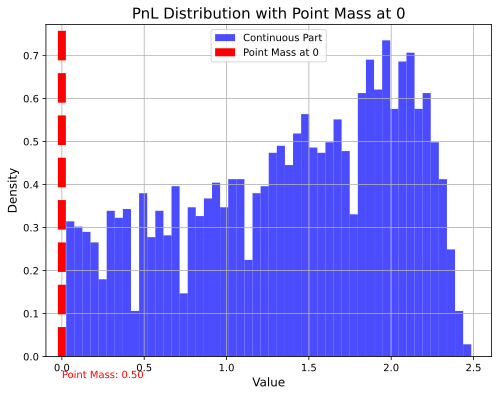

In [13]:
# Plot the PnL histogram
PnL_continuous_part = [x for x in PnL_distirbution if x > 0]  # All values less than 1
PnL_point_mass_count = len([x for x in PnL_distirbution if x == 0])  # Count the number of occurrences of 1
# Plot the histogram for the continuous part
plt.figure(figsize=(8, 6))
plt.hist(PnL_continuous_part, bins=50, density=True, alpha=0.7, color='blue', label='Continuous Part')
# Add the point mass at 1
plt.axvline(x=0, color='red', linestyle='--', linewidth=8, label='Point Mass at 0')
# Annotate the point mass with its relative probability
PnL_relative_mass_prob = PnL_point_mass_count / len(PnL_distirbution)  # The probability mass at 1
plt.text(0., -0.05, f'Point Mass: {PnL_relative_mass_prob:.2f}', color='red')
plt.title("PnL Distribution with Point Mass at 0", fontsize=15)
plt.xlabel("Value", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend()
plt.grid(True);

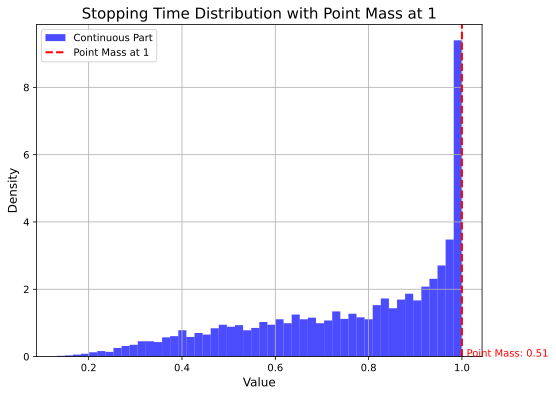

In [14]:
# Separate the continuous part and the point mass part
stopping_time_continuous_part = [x for x in stopping_time_distribution if x < 1]  # All values less than 1
stopping_time_point_mass_count = len([x for x in stopping_time_distribution if x == 1])  # Count the number of occurrences of 1
# Plot the histogram for the continuous part
plt.figure(figsize=(8, 6))
plt.hist(stopping_time_continuous_part, bins=50, density=True, alpha=0.7, color='blue', label='Continuous Part')
# Add the point mass at 1
plt.axvline(x=1, color='red', linestyle='--', linewidth=2, label='Point Mass at 1')
# Annotate the point mass with its relative probability
stopping_time_relative_mass_prob = stopping_time_point_mass_count / len(stopping_time_distribution)  # The probability mass at 1
plt.text(1+0.01, 0., f'Point Mass: {stopping_time_relative_mass_prob:.2f}', color='red')
plt.title("Stopping Time Distribution with Point Mass at 1", fontsize=15)
plt.xlabel("Value", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend()
plt.grid(True);

<Figure size 800x600 with 0 Axes>

(array([0.57532829, 0.59036955, 0.67497665, 0.29706493, 0.86487259,
        0.48884103, 0.79342659, 0.5659275 , 0.66557586, 0.56028703,
        0.59977034, 0.6994187 , 0.64489413, 0.41927519, 0.49824182,
        0.59224971, 0.33090777, 0.33654825, 0.32150698, 0.31398635,
        0.30270541, 0.21809831, 0.21621815, 0.17109436, 0.09024757,
        0.1692142 , 0.19741657, 0.11092931, 0.0488841 , 0.05640473,
        0.03948331, 0.02444205, 0.05452458, 0.00940079, 0.02444205,
        0.01692142, 0.00564047, 0.01504126, 0.00376032, 0.00376032,
        0.00376032, 0.00188016, 0.        , 0.00188016, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00188016]),
 array([0.02824431, 0.1074742 , 0.18670409, 0.26593398, 0.34516387,
        0.42439376, 0.50362365, 0.58285354, 0.66208343, 0.74131332,
        0.8205432 , 0.89977309, 0.97900298, 1.05823287, 1.13746276,
        1.21669265, 1.29592254, 1.37515243, 1.45438232, 1.53361221,
        1.6128421 , 1.69207199, 1.77130188, 1.

Text(0.0, -0.05, 'Point Mass: 0.33')

Text(0.5, 1.0, 'PnL Distribution of sigma = 0.1; r = 0.0 with Point Mass at 0')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Density')

<Figure size 800x600 with 0 Axes>

(array([ 13.80542632,  15.77763008,   0.        ,  10.84712068,
         13.80542632,   1.97220376,   0.49305094,   0.49305094,
          2.4652547 ,   0.49305094,   0.        ,   0.        ,
          1.47915282,   0.        ,   0.        ,   0.        ,
          3.45135658,   0.        ,   3.94440752,   0.49305094,
          0.        ,   3.45135658,   0.98610188,   0.49305094,
          0.        ,   3.45135658,   1.47915282,   0.        ,
          0.        ,  10.84712068,  11.34017162,   1.47915282,
          1.97220376,  69.52018255,   1.47915282,  50.78424683,
          2.4652547 ,  62.61746939,  58.67306187, 228.77563618,
        272.65716985, 151.3666386 , 167.63731962, 268.71276233,
         30.56915828, 186.86630628, 305.69158283, 243.56716439,
        464.94703647, 340.69819958]),
 array([0.9832  , 0.983532, 0.983864, 0.984196, 0.984528, 0.98486 ,
        0.985192, 0.985524, 0.985856, 0.986188, 0.98652 , 0.986852,
        0.987184, 0.987516, 0.987848, 0.98818 , 0.988512, 

Text(1.01, 0.0, 'Point Mass: 0.39')

Text(0.5, 1.0, 'Stopping Time Distribution of sigma = 0.1; r = 0.0 with Point Mass at 1')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Density')

<Figure size 800x600 with 0 Axes>

(array([0.54658811, 0.55512855, 0.23059186, 0.51242635, 0.4355624 ,
        0.58074987, 0.23059186, 0.55512855, 0.29037493, 0.58074987,
        0.35869845, 0.56366899, 0.25621318, 0.74301821, 0.40994108,
        0.7173969 , 0.29037493, 0.8711248 , 0.30745581, 0.4782646 ,
        0.61491163, 0.46118372, 0.96506963, 0.40140064, 1.1529593 ,
        0.58929031, 1.13587842, 0.62345207, 0.54658811, 1.14441886,
        0.76009909, 1.03339315, 1.23836369, 0.94798876, 0.94798876,
        1.97284147, 0.98215051, 1.37501072, 1.25544457, 2.36570167,
        2.00700322, 1.59706214, 2.07532674, 1.87889663, 2.12656937,
        2.04970542, 2.14365025, 1.7849518 , 1.03339315, 0.21351098]),
 array([0.02623968, 0.04754427, 0.06884885, 0.09015344, 0.11145802,
        0.13276261, 0.15406719, 0.17537177, 0.19667636, 0.21798094,
        0.23928553, 0.26059011, 0.2818947 , 0.30319928, 0.32450387,
        0.34580845, 0.36711304, 0.38841762, 0.4097222 , 0.43102679,
        0.45233137, 0.47363596, 0.49494054, 0.

Text(0.0, -0.05, 'Point Mass: 0.45')

Text(0.5, 1.0, 'PnL Distribution of sigma = 0.1; r = 0.02 with Point Mass at 0')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Density')

<Figure size 800x600 with 0 Axes>

(array([0.04023364, 0.0905257 , 0.16093458, 0.14081776, 0.3621028 ,
        0.44257009, 0.50292056, 0.57332944, 0.66385514, 0.78455607,
        0.87508177, 0.79461449, 0.86502336, 0.91531542, 0.78455607,
        1.03601635, 1.00584112, 1.07625   , 1.04607477, 0.93543224,
        1.3478271 , 1.13660047, 1.07625   , 0.99578271, 1.00584112,
        1.15671729, 1.11648364, 1.06619159, 1.22712617, 0.91531542,
        1.24724299, 1.06619159, 0.97566589, 1.20700934, 1.01589953,
        1.19695093, 1.05613318, 0.99578271, 1.21706776, 1.20700934,
        1.00584112, 1.10642523, 1.33776869, 1.47858645, 1.3478271 ,
        1.5288785 , 1.45846962, 1.86080607, 2.56489486, 5.95457943]),
 array([0.0902  , 0.108392, 0.126584, 0.144776, 0.162968, 0.18116 ,
        0.199352, 0.217544, 0.235736, 0.253928, 0.27212 , 0.290312,
        0.308504, 0.326696, 0.344888, 0.36308 , 0.381272, 0.399464,
        0.417656, 0.435848, 0.45404 , 0.472232, 0.490424, 0.508616,
        0.526808, 0.545   , 0.563192, 0.581384

Text(1.01, 0.0, 'Point Mass: 0.45')

Text(0.5, 1.0, 'Stopping Time Distribution of sigma = 0.1; r = 0.02 with Point Mass at 1')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Density')

<Figure size 800x600 with 0 Axes>

(array([0.65210709, 0.21264362, 0.34022979, 0.14176241, 0.22681986,
        0.26934858, 0.22681986, 0.42528723, 0.28352482, 0.53869716,
        0.29770106, 0.28352482, 0.29770106, 0.3118773 , 0.34022979,
        0.51034468, 0.28352482, 0.4819922 , 0.49616844, 0.34022979,
        0.63793085, 0.63793085, 0.58122588, 0.72298829, 0.73716454,
        0.39693475, 0.52452092, 0.69463581, 0.92145567, 1.19080425,
        0.56704964, 0.62375461, 1.68697269, 0.75134078, 1.38927162,
        1.54521028, 1.87126382, 1.14827553, 2.28237481, 2.65095708,
        1.19080425, 2.04137871, 3.2463592 , 4.08275743, 3.09042055,
        4.05440494, 5.40114785, 5.67049643, 4.60727835, 1.29003794]),
 array([0.02423466, 0.04005802, 0.05588139, 0.07170475, 0.08752812,
        0.10335148, 0.11917485, 0.13499821, 0.15082158, 0.16664494,
        0.18246831, 0.19829167, 0.21411504, 0.2299384 , 0.24576177,
        0.26158513, 0.2774085 , 0.29323186, 0.30905523, 0.32487859,
        0.34070196, 0.35652532, 0.37234869, 0.

Text(0.0, -0.05, 'Point Mass: 0.55')

Text(0.5, 1.0, 'PnL Distribution of sigma = 0.1; r = 0.04 with Point Mass at 0')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Density')

<Figure size 800x600 with 0 Axes>

(array([0.10670518, 0.28454715, 0.42682073, 0.62837497, 0.75879241,
        0.8654976 , 1.38716738, 1.20932541, 1.2448938 , 1.09076409,
        1.16190088, 1.15004475, 1.31603059, 1.35159898, 1.22118154,
        1.13818862, 1.23303767, 1.4345919 , 1.0551957 , 1.06705183,
        1.06705183, 1.09076409, 0.91292212, 0.93663438, 0.91292212,
        0.8654976 , 0.94849052, 1.10262022, 1.09076409, 1.09076409,
        0.92477825, 0.93663438, 0.79436081, 0.85364146, 0.97220278,
        1.0551957 , 0.94849052, 1.0551957 , 0.8654976 , 0.74693628,
        1.00777117, 0.77064854, 0.98405891, 0.8654976 , 1.10262022,
        0.96034665, 1.20932541, 1.31603059, 1.54129709, 3.43827812]),
 array([0.0474  , 0.066448, 0.085496, 0.104544, 0.123592, 0.14264 ,
        0.161688, 0.180736, 0.199784, 0.218832, 0.23788 , 0.256928,
        0.275976, 0.295024, 0.314072, 0.33312 , 0.352168, 0.371216,
        0.390264, 0.409312, 0.42836 , 0.447408, 0.466456, 0.485504,
        0.504552, 0.5236  , 0.542648, 0.561696

Text(1.01, 0.0, 'Point Mass: 0.56')

Text(0.5, 1.0, 'Stopping Time Distribution of sigma = 0.1; r = 0.04 with Point Mass at 1')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Density')

<Figure size 800x600 with 0 Axes>

(array([0.34476384, 0.37254102, 0.33986198, 0.39051449, 0.36273731,
        0.34966569, 0.29901318, 0.47711393, 0.34312988, 0.45423861,
        0.27613786, 0.47384603, 0.271236  , 0.35456755, 0.25326253,
        0.32515641, 0.40685401, 0.39214844, 0.23692302, 0.20424398,
        0.27450391, 0.12581429, 0.23365511, 0.13071615, 0.23692302,
        0.19117236, 0.15522542, 0.08169759, 0.1830026 , 0.12581429,
        0.07842969, 0.11110872, 0.07679574, 0.08006364, 0.07025993,
        0.0408488 , 0.02777718, 0.02450928, 0.02941113, 0.01143766,
        0.01960742, 0.02124137, 0.01143766, 0.00816976, 0.00490186,
        0.00653581, 0.        , 0.00163395, 0.00163395, 0.00163395]),
 array([9.30810984e-13, 1.07597248e-01, 2.15194496e-01, 3.22791744e-01,
        4.30388992e-01, 5.37986240e-01, 6.45583488e-01, 7.53180736e-01,
        8.60777984e-01, 9.68375232e-01, 1.07597248e+00, 1.18356973e+00,
        1.29116698e+00, 1.39876422e+00, 1.50636147e+00, 1.61395872e+00,
        1.72155597e+00, 1.8291

Text(0.0, -0.05, 'Point Mass: 0.43')

Text(0.5, 1.0, 'PnL Distribution of sigma = 0.2; r = 0.0 with Point Mass at 0')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Density')

<Figure size 800x600 with 0 Axes>

(array([ 55.41450046,  28.21101842,  47.35420949,   0.        ,
          0.        ,  21.662032  ,   0.        ,  89.16696893,
         19.64695926,   0.        ,  11.08290009,  22.16580019,
          0.        ,   0.        ,   5.54145005,  27.20348205,
          0.        ,   2.51884093,  40.80522307,   0.50376819,
         44.83536856,  82.11421432,   0.        ,  40.30145488,
         72.0388506 ,  67.00116874,  70.52754604,   4.53391367,
         62.97102325,  21.15826381,  28.7147866 ,  46.34667311,
         35.76754121,  20.15072744,  64.986096  ,  11.58666828,
        123.42320558,  72.0388506 , 129.972192  ,  63.47479144,
         41.81275944,  32.74493209,  38.79015032, 181.35654697,
         75.5652279 , 232.23713376, 155.1606013 , 267.50090678,
        153.64929674, 165.7397332 ]),
 array([0.9818 , 0.98216, 0.98252, 0.98288, 0.98324, 0.9836 , 0.98396,
        0.98432, 0.98468, 0.98504, 0.9854 , 0.98576, 0.98612, 0.98648,
        0.98684, 0.9872 , 0.98756, 0.98792, 0.98828,

Text(1.01, 0.0, 'Point Mass: 0.45')

Text(0.5, 1.0, 'Stopping Time Distribution of sigma = 0.2; r = 0.0 with Point Mass at 1')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Density')

<Figure size 800x600 with 0 Axes>

(array([0.39611012, 0.337736  , 0.30437936, 0.13342657, 0.35441432,
        0.32105768, 0.32522726, 0.32522726, 0.11257867, 0.25017481,
        0.30437936, 0.36275348, 0.337736  , 0.17512237, 0.32522726,
        0.3794318 , 0.3794318 , 0.34190558, 0.4419755 , 0.14593531,
        0.36275348, 0.3794318 , 0.4002797 , 0.42529718, 0.41695802,
        0.38777096, 0.36692306, 0.26268355, 0.43780592, 0.52953669,
        0.51285837, 0.52119753, 0.54621501, 0.55038459, 0.54204543,
        0.60041955, 0.67130242, 0.64211536, 0.64211536, 0.47950173,
        0.53370627, 0.64628494, 0.74218528, 0.59624997, 0.57123249,
        0.64211536, 0.46699299, 0.35024474, 0.19597027, 0.03752622]),
 array([0.02623968, 0.07498609, 0.12373249, 0.17247889, 0.22122529,
        0.26997169, 0.31871809, 0.36746449, 0.4162109 , 0.4649573 ,
        0.5137037 , 0.5624501 , 0.6111965 , 0.6599429 , 0.70868931,
        0.75743571, 0.80618211, 0.85492851, 0.90367491, 0.95242131,
        1.00116772, 1.04991412, 1.09866052, 1.

Text(0.0, -0.05, 'Point Mass: 0.51')

Text(0.5, 1.0, 'PnL Distribution of sigma = 0.2; r = 0.02 with Point Mass at 0')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Density')

<Figure size 800x600 with 0 Axes>

(array([0.02393718, 0.02393718, 0.01196859, 0.13165448, 0.15559165,
        0.20346601, 0.23937177, 0.25134036, 0.32315189, 0.37102625,
        0.49071214, 0.49071214, 0.58646085, 0.67024097, 0.68220955,
        0.69417814, 0.6343352 , 0.65827238, 0.78992685, 0.64630379,
        0.89764415, 1.01733004, 0.86173838, 0.94551851, 0.81386403,
        1.0532358 , 1.02929863, 1.01733004, 1.0532358 , 1.08914157,
        1.13701592, 1.30457617, 1.10111016, 1.30457617, 1.08914157,
        1.19685887, 1.20882746, 1.47213641, 1.25670181, 1.41229346,
        1.59182229, 1.54394794, 1.31654475, 1.52001076, 1.86709983,
        2.03466008, 2.03466008, 2.98017858, 3.63845096, 9.4073107 ]),
 array([0.1418 , 0.15896, 0.17612, 0.19328, 0.21044, 0.2276 , 0.24476,
        0.26192, 0.27908, 0.29624, 0.3134 , 0.33056, 0.34772, 0.36488,
        0.38204, 0.3992 , 0.41636, 0.43352, 0.45068, 0.46784, 0.485  ,
        0.50216, 0.51932, 0.53648, 0.55364, 0.5708 , 0.58796, 0.60512,
        0.62228, 0.63944, 0.6566 ,

Text(1.01, 0.0, 'Point Mass: 0.51')

Text(0.5, 1.0, 'Stopping Time Distribution of sigma = 0.2; r = 0.02 with Point Mass at 1')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Density')

<Figure size 800x600 with 0 Axes>

(array([0.36895667, 0.1325938 , 0.36895667, 0.1441237 , 0.34589688,
        0.16141854, 0.16718349, 0.35166183, 0.14988865, 0.25365771,
        0.19600823, 0.2767175 , 0.19600823, 0.40354636, 0.20177318,
        0.24212782, 0.41507625, 0.16141854, 0.43813605, 0.28248245,
        0.44966594, 0.20753813, 0.39778141, 0.44390099, 0.24789276,
        0.65143912, 0.32283709, 0.65143912, 0.40354636, 0.34013193,
        0.66873397, 0.34589688, 0.43813605, 1.1529896 , 0.51308037,
        0.49002058, 1.02616074, 0.61684943, 0.69755871, 0.66873397,
        1.21640402, 1.13569475, 0.997336  , 0.95698137, 1.08381022,
        1.22793392, 1.12416486, 0.90509683, 0.36895667, 0.09800412]),
 array([0.05241052, 0.09224108, 0.13207164, 0.1719022 , 0.21173277,
        0.25156333, 0.29139389, 0.33122446, 0.37105502, 0.41088558,
        0.45071615, 0.49054671, 0.53037727, 0.57020784, 0.6100384 ,
        0.64986896, 0.68969953, 0.72953009, 0.76936065, 0.80919122,
        0.84902178, 0.88885234, 0.92868291, 0.

Text(0.0, -0.05, 'Point Mass: 0.56')

Text(0.5, 1.0, 'PnL Distribution of sigma = 0.2; r = 0.04 with Point Mass at 0')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Density')

<Figure size 800x600 with 0 Axes>

(array([0.03788463, 0.08839747, 0.11365389, 0.15153853, 0.30307705,
        0.37884631, 0.45461558, 0.50512842, 0.74506442, 0.71980799,
        0.71980799, 0.61878231, 0.82083368, 1.04814147, 0.88397473,
        0.99762862, 0.89660294, 0.88397473, 1.02288504, 0.87134652,
        0.93448757, 0.89660294, 1.07339789, 0.85871831, 1.03551326,
        0.99762862, 1.03551326, 1.12391073, 0.9723722 , 0.98500041,
        1.2123082 , 1.03551326, 0.95974399, 0.83346189, 1.14916715,
        1.12391073, 1.22493641, 1.47750062, 1.25019283, 1.02288504,
        1.02288504, 1.36384673, 1.38910315, 1.31333388, 1.60378272,
        1.55326988, 1.74269304, 2.03314188, 2.79083451, 6.20045132]),
 array([0.082   , 0.100356, 0.118712, 0.137068, 0.155424, 0.17378 ,
        0.192136, 0.210492, 0.228848, 0.247204, 0.26556 , 0.283916,
        0.302272, 0.320628, 0.338984, 0.35734 , 0.375696, 0.394052,
        0.412408, 0.430764, 0.44912 , 0.467476, 0.485832, 0.504188,
        0.522544, 0.5409  , 0.559256, 0.577612

Text(1.01, 0.0, 'Point Mass: 0.57')

Text(0.5, 1.0, 'Stopping Time Distribution of sigma = 0.2; r = 0.04 with Point Mass at 1')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Density')

<Figure size 800x600 with 0 Axes>

(array([0.28885721, 0.25419434, 0.26904986, 0.27565231, 0.33012252,
        0.14690452, 0.24264005, 0.3796409 , 0.38294213, 0.16506126,
        0.34992987, 0.29711027, 0.21127841, 0.28225476, 0.26739924,
        0.16176004, 0.35983355, 0.30701395, 0.16671187, 0.21953148,
        0.23768822, 0.25749557, 0.22613393, 0.19477229, 0.23768822,
        0.12049472, 0.18651923, 0.183218  , 0.09573553, 0.18982045,
        0.1171935 , 0.10398859, 0.15020575, 0.0660245 , 0.08088002,
        0.08253063, 0.06107267, 0.06932573, 0.07097634, 0.05447022,
        0.03466286, 0.0264098 , 0.0264098 , 0.01155429, 0.0132049 ,
        0.01650613, 0.00660245, 0.00330123, 0.        , 0.00495184]),
 array([0.08449383, 0.20515419, 0.32581455, 0.44647491, 0.56713527,
        0.68779563, 0.80845599, 0.92911635, 1.04977672, 1.17043708,
        1.29109744, 1.4117578 , 1.53241816, 1.65307852, 1.77373888,
        1.89439924, 2.0150596 , 2.13571996, 2.25638032, 2.37704068,
        2.49770104, 2.61836141, 2.73902177, 2.

Text(0.0, -0.05, 'Point Mass: 0.50')

Text(0.5, 1.0, 'PnL Distribution of sigma = 0.3; r = 0.0 with Point Mass at 0')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Density')

<Figure size 800x600 with 0 Axes>

(array([1.17308328e-01, 5.86541638e-02, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.17308328e-01,
        0.00000000e+00, 0.00000000e+00, 1.75962491e-01, 5.86541638e-02,
        3.51924983e-01, 0.00000000e+00, 1.17308328e-01, 4.69233310e-01,
        2.34616655e-01, 1.75962491e-01, 5.86541638e-02, 4.69233310e-01,
        3.51924983e-01, 2.93270819e-01, 7.62504129e-01, 5.86541638e-01,
        8.21158293e-01, 1.17308328e+00, 7.62504129e-01, 1.87693324e+00,
        4.69233310e-01, 2.11154990e+00, 2.05289573e+00, 1.40769993e+00,
        1.64231659e+00, 2.46347488e+00, 3.57790399e+00, 3.34328734e+00,
        2.75674570e+00, 5.74810805e+00, 5.63079972e+00, 4.98560392e+00,
        6.39330385e+00, 9.32601204e+00, 8.56350791e+00, 1.40769993e+01,
        1.09096745e+01, 1.99424157e+01, 2.19953114e+01, 2.18193489e+01,
        4.63367894e+01, 7.44321338e+01]),
 array([0.8206  , 0.824184, 0.827768, 0.831352, 0.834936, 0.83852 ,
        0.842104, 0.845688

Text(1.01, 0.0, 'Point Mass: 0.52')

Text(0.5, 1.0, 'Stopping Time Distribution of sigma = 0.3; r = 0.0 with Point Mass at 1')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Density')

<Figure size 800x600 with 0 Axes>

(array([0.27146179, 0.27146179, 0.23566463, 0.24461392, 0.05966193,
        0.20881676, 0.22373225, 0.25952941, 0.29830966, 0.10142529,
        0.25058012, 0.2625125 , 0.24163083, 0.21776605, 0.27444489,
        0.2684787 , 0.24759702, 0.2684787 , 0.22969844, 0.23566463,
        0.23268154, 0.28041108, 0.25952941, 0.25952941, 0.24759702,
        0.28936037, 0.28936037, 0.28339418, 0.30427586, 0.30725895,
        0.51905881, 0.29830966, 0.30427586, 0.32217444, 0.32217444,
        0.49221094, 0.34603921, 0.27444489, 0.33112373, 0.5309912 ,
        0.31322515, 0.32217444, 0.51309262, 0.30725895, 0.25952941,
        0.34305611, 0.19091818, 0.17003651, 0.05966193, 0.03878026]),
 array([0.05440988, 0.12749079, 0.2005717 , 0.27365261, 0.34673352,
        0.41981442, 0.49289533, 0.56597624, 0.63905715, 0.71213806,
        0.78521897, 0.85829988, 0.93138079, 1.0044617 , 1.0775426 ,
        1.15062351, 1.22370442, 1.29678533, 1.36986624, 1.44294715,
        1.51602806, 1.58910897, 1.66218987, 1.

Text(0.0, -0.05, 'Point Mass: 0.54')

Text(0.5, 1.0, 'PnL Distribution of sigma = 0.3; r = 0.02 with Point Mass at 0')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Density')

<Figure size 800x600 with 0 Axes>

(array([ 0.01320504,  0.02641007,  0.05282015,  0.09243526,  0.09243526,
         0.1056403 ,  0.11884534,  0.11884534,  0.17166549,  0.26410075,
         0.35653601,  0.43576623,  0.27730579,  0.46217631,  0.48858638,
         0.44897127,  0.62063676,  0.46217631,  0.6338418 ,  0.69986698,
         0.71307202,  0.83191736,  0.89794254,  0.93755766,  0.67345691,
         0.72627706,  0.95076269,  0.91114758,  1.21486344,  0.97717277,
         0.85832743,  1.12242818,  1.18845337,  1.2016584 ,  1.06960803,
         1.3072987 ,  1.3072987 ,  1.25447855,  1.43934908,  1.76947501,
         1.50537427,  1.82229516,  1.78268005,  1.82229516,  1.80909013,
         2.45613696,  2.3637017 ,  3.20882409,  4.29163716, 11.58081781]),
 array([0.1656  , 0.182284, 0.198968, 0.215652, 0.232336, 0.24902 ,
        0.265704, 0.282388, 0.299072, 0.315756, 0.33244 , 0.349124,
        0.365808, 0.382492, 0.399176, 0.41586 , 0.432544, 0.449228,
        0.465912, 0.482596, 0.49928 , 0.515964, 0.532648, 0.5493

Text(1.01, 0.0, 'Point Mass: 0.55')

Text(0.5, 1.0, 'Stopping Time Distribution of sigma = 0.3; r = 0.02 with Point Mass at 1')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Density')

<Figure size 800x600 with 0 Axes>

(array([0.28828793, 0.27331194, 0.11980797, 0.14975996, 0.12355197,
        0.26582394, 0.10483198, 0.24710394, 0.09359998, 0.28454393,
        0.28079993, 0.08985598, 0.26956794, 0.13478397, 0.28828793,
        0.22089595, 0.07862398, 0.33695992, 0.17222396, 0.25459194,
        0.37439991, 0.13852797, 0.34444792, 0.30700793, 0.20591995,
        0.25833594, 0.26582394, 0.37814391, 0.21340795, 0.39686391,
        0.4268159 , 0.22463995, 0.4305599 , 0.46425589, 0.47174389,
        0.19468795, 0.61027186, 0.54287987, 0.26956794, 0.59529586,
        0.53913587, 0.47548789, 0.52790388, 0.71884783, 0.53913587,
        0.49420788, 0.55785587, 0.25833594, 0.33695992, 0.10108798]),
 array([0.02423466, 0.08776798, 0.1513013 , 0.21483462, 0.27836794,
        0.34190126, 0.40543458, 0.4689679 , 0.53250122, 0.59603454,
        0.65956786, 0.72310118, 0.7866345 , 0.85016782, 0.91370114,
        0.97723446, 1.04076778, 1.10430111, 1.16783443, 1.23136775,
        1.29490107, 1.35843439, 1.42196771, 1.

Text(0.0, -0.05, 'Point Mass: 0.58')

Text(0.5, 1.0, 'PnL Distribution of sigma = 0.3; r = 0.04 with Point Mass at 0')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Density')

<Figure size 800x600 with 0 Axes>

(array([0.04069898, 0.09496428, 0.16279591, 0.12209694, 0.21706122,
        0.20349489, 0.33915815, 0.35272448, 0.27132652, 0.50195407,
        0.44768876, 0.63761733, 0.54265304, 0.58335202, 0.624051  ,
        0.84111222, 0.69188263, 0.80041324, 0.80041324, 0.80041324,
        0.96320915, 0.99034181, 0.82754589, 1.03104079, 0.96320915,
        0.89537752, 0.85467855, 0.81397957, 1.08530609, 0.96320915,
        1.01747446, 1.05817344, 1.04460711, 1.32949996, 1.1938367 ,
        0.92251018, 1.28880098, 1.20740302, 1.37019894, 1.1938367 ,
        1.5601275 , 1.45159689, 1.45159689, 1.41089792, 1.57369383,
        1.8178877 , 2.21131116, 2.71326522, 3.21521929, 8.89950994]),
 array([0.1132  , 0.130932, 0.148664, 0.166396, 0.184128, 0.20186 ,
        0.219592, 0.237324, 0.255056, 0.272788, 0.29052 , 0.308252,
        0.325984, 0.343716, 0.361448, 0.37918 , 0.396912, 0.414644,
        0.432376, 0.450108, 0.46784 , 0.485572, 0.503304, 0.521036,
        0.538768, 0.5565  , 0.574232, 0.591964

Text(1.01, 0.0, 'Point Mass: 0.58')

Text(0.5, 1.0, 'Stopping Time Distribution of sigma = 0.3; r = 0.04 with Point Mass at 1')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Density')

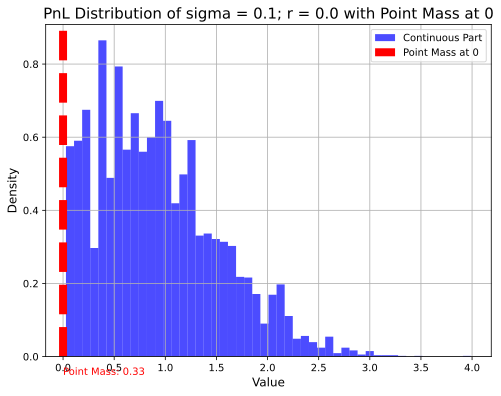

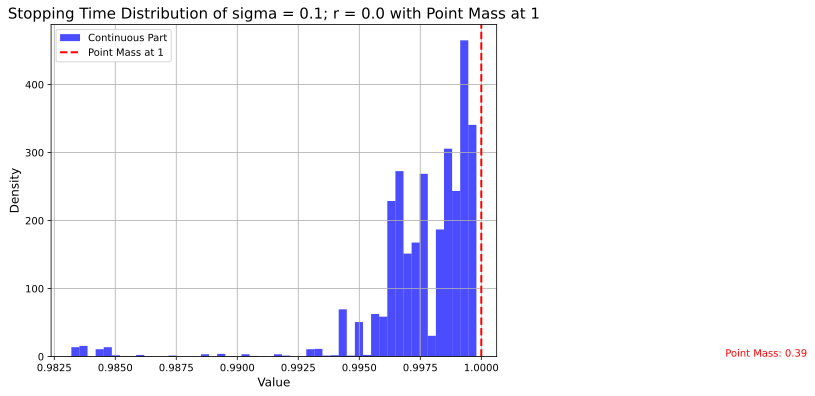

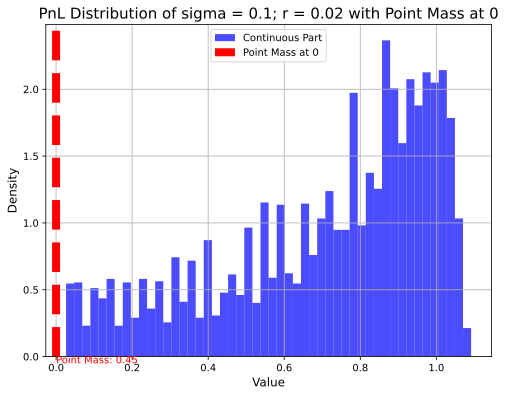

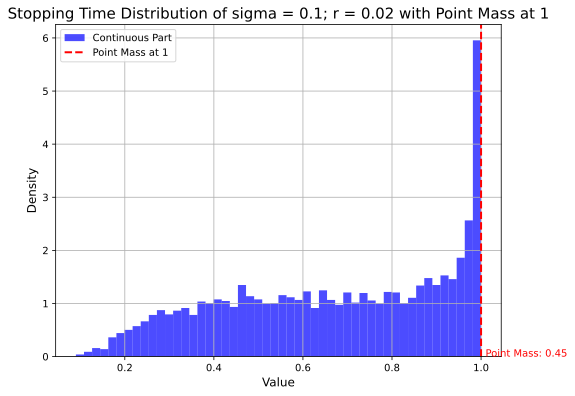

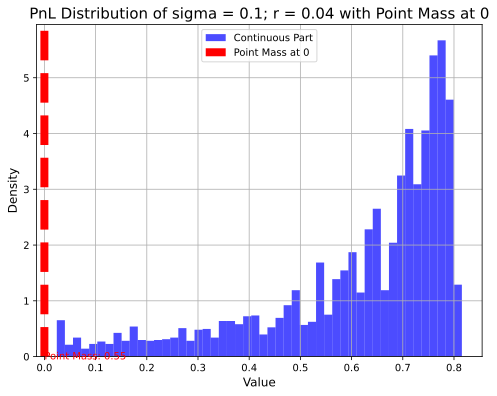

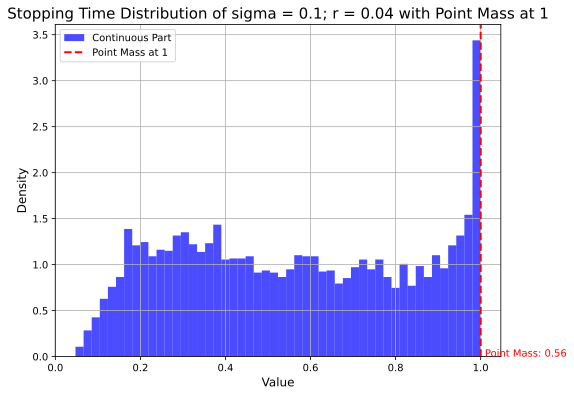

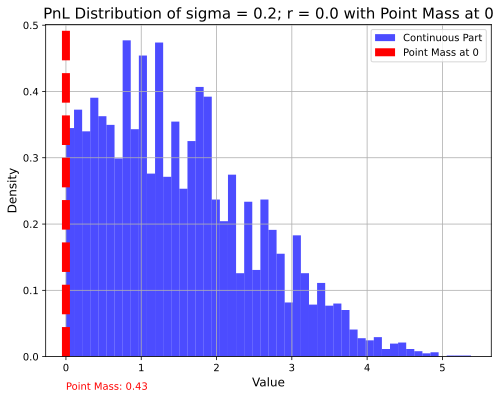

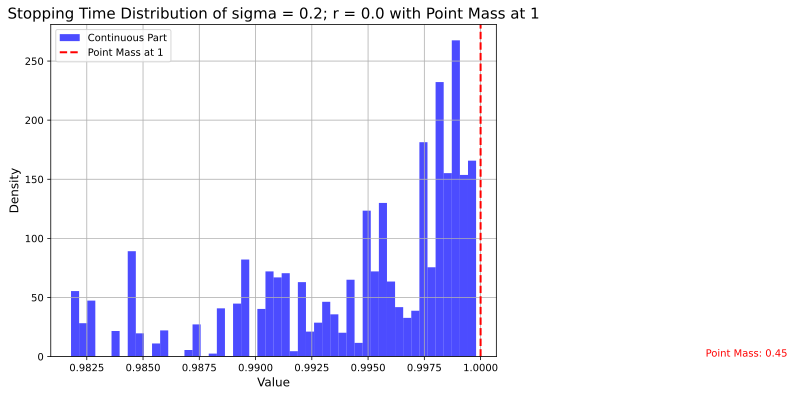

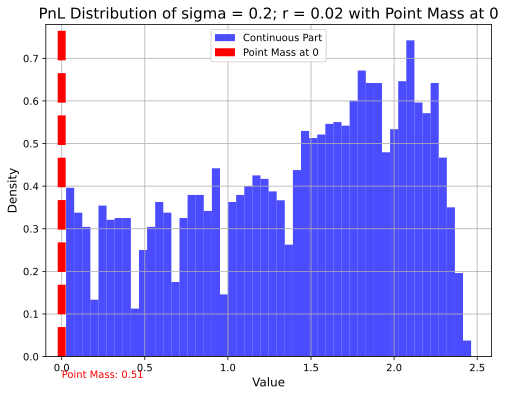

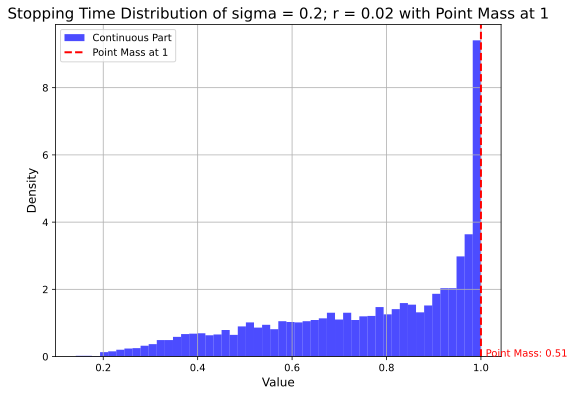

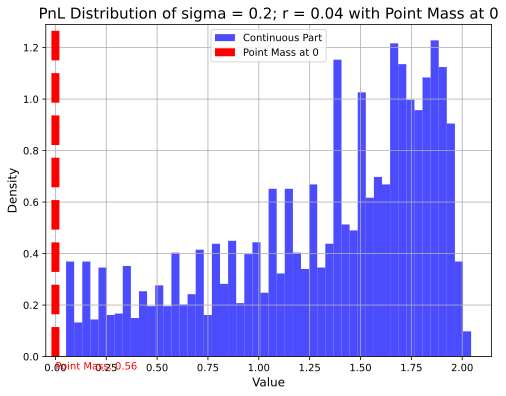

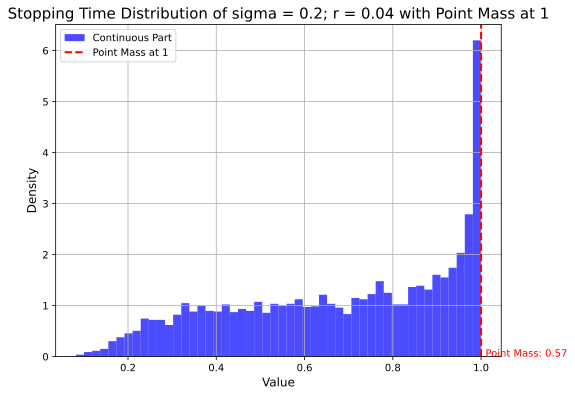

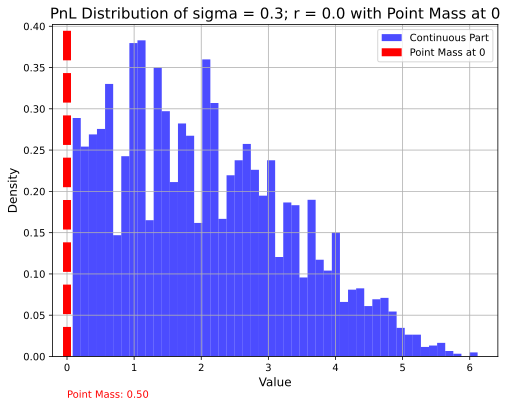

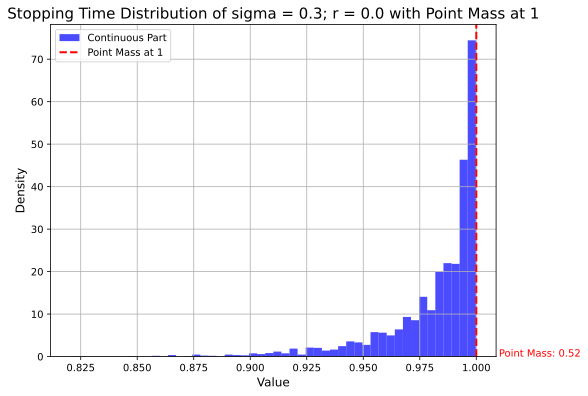

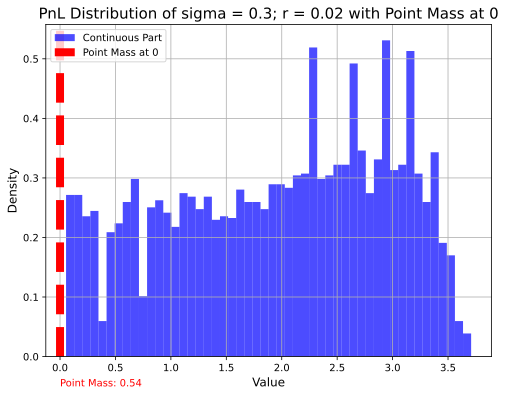

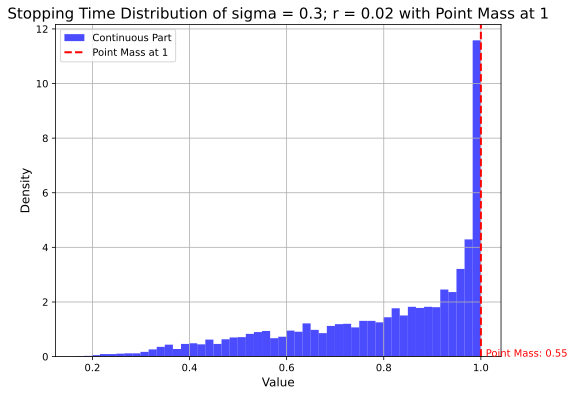

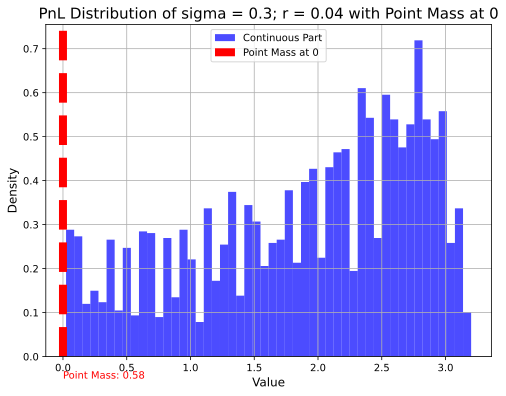

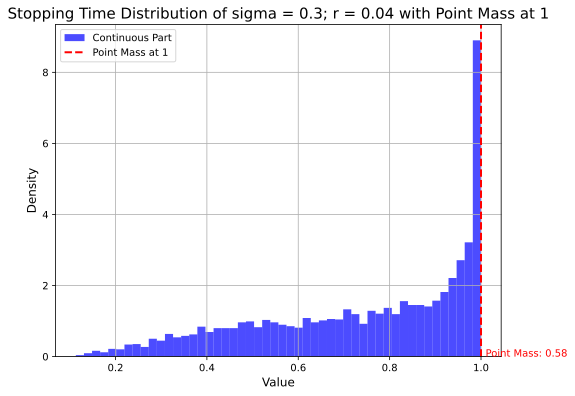

In [15]:
# ii)
for sigma_new in [0.10, 0.20, 0.30]:
    for r_new in [0.00, 0.02, 0.04]:
        tree = BinomialModelAmericanPut(S0, K, T, r_new, sigma_new, mu, N)
        sample_paths = tree.gen_simulation_paths(10000)
        PnL_distirbution = []
        stopping_time_distribution = []
        for path in sample_paths:
            PnL_early_exercise, stopping_time_early_exercise = tree.fetch_path_result(path)
            PnL_distirbution.append(PnL_early_exercise)
            stopping_time_distribution.append(stopping_time_early_exercise / tree.N)

        # Plot the PnL histogram
        PnL_continuous_part = [x for x in PnL_distirbution if x > 0]
        PnL_point_mass_count = len([x for x in PnL_distirbution if x == 0])
        plt.figure(figsize=(8, 6))
        plt.hist(PnL_continuous_part, bins=50, density=True, alpha=0.7, color='blue', label='Continuous Part')
        plt.axvline(x=0, color='red', linestyle='--', linewidth=8, label='Point Mass at 0')
        PnL_relative_mass_prob = PnL_point_mass_count / len(PnL_distirbution)
        plt.text(0., -0.05, f'Point Mass: {PnL_relative_mass_prob:.2f}', color='red')
        plt.title(f"PnL Distribution of sigma = {sigma_new}; r = {r_new} with Point Mass at 0", fontsize=15)
        plt.xlabel("Value", fontsize=12)
        plt.ylabel("Density", fontsize=12)
        plt.legend()
        plt.grid(True)
        # plt.savefig(f'/content/drive/My Drive/SyncWorkspace/MMF/MMF1928H/Project 1/PnL_distribution_plot-sigma={sigma_new}&r={r_new}.jpg')

        # Separate the continuous part and the point mass part
        stopping_time_continuous_part = [x for x in stopping_time_distribution if x < 1]
        stopping_time_point_mass_count = len([x for x in stopping_time_distribution if x == 1])
        plt.figure(figsize=(8, 6))
        plt.hist(stopping_time_continuous_part, bins=50, density=True, alpha=0.7, color='blue', label='Continuous Part')
        plt.axvline(x=1, color='red', linestyle='--', linewidth=2, label='Point Mass at 1')
        stopping_time_relative_mass_prob = stopping_time_point_mass_count / len(stopping_time_distribution)
        plt.text(1+0.01, 0., f'Point Mass: {stopping_time_relative_mass_prob:.2f}', color='red')
        plt.title(f"Stopping Time Distribution of sigma = {sigma_new}; r = {r_new} with Point Mass at 1", fontsize=15)
        plt.xlabel("Value", fontsize=12)
        plt.ylabel("Density", fontsize=12)
        plt.legend()
        plt.grid(True)
        # plt.savefig(f'/content/drive/My Drive/SyncWorkspace/MMF/MMF1928H/Project 1/Stopping_time_distribution_plot-sigma={sigma_new}&r={r_new}.jpg')

<Figure size 800x600 with 0 Axes>

(array([0.98652503, 0.74993758, 0.76332932, 0.80350455, 0.38836053,
        0.74547366, 0.77672106, 0.82582412, 0.46871099, 0.9775972 ,
        0.62048407, 0.78564889, 0.90617457, 0.40621619, 0.83475195,
        0.42853576, 0.77672106, 0.72761801, 0.55352536, 0.5669171 ,
        0.49549447, 0.58030884, 0.66958712, 0.66512321, 0.30801008,
        0.62494798, 0.37050487, 0.54906144, 0.5044223 , 0.50888621,
        0.20087614, 0.54013361, 0.29461833, 0.42853576, 0.43299967,
        0.29461833, 0.14730917, 0.27229876, 0.16070091, 0.20980397,
        0.17409265, 0.21426788, 0.14730917, 0.04910306, 0.10267003,
        0.05356697, 0.04017523, 0.04463914, 0.02231957, 0.01339174]),
 array([0.02623968, 0.06932019, 0.1124007 , 0.15548121, 0.19856172,
        0.24164223, 0.28472274, 0.32780324, 0.37088375, 0.41396426,
        0.45704477, 0.50012528, 0.54320579, 0.5862863 , 0.6293668 ,
        0.67244731, 0.71552782, 0.75860833, 0.80168884, 0.84476935,
        0.88784986, 0.93093036, 0.97401087, 1.

Text(-0.55, 0.0, 'Point Mass: 0.48')

Text(0.5, 1.0, 'PnL Distribution of Miss-matched realized sigma = 0.1 with Point Mass at 0')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Density')

<Figure size 800x600 with 0 Axes>

(array([1.75239696e-02, 1.75239696e-02, 1.75239696e-02, 0.00000000e+00,
        1.75239696e-02, 5.25719089e-02, 1.75239696e-02, 7.00958785e-02,
        5.25719089e-02, 5.25719089e-02, 1.75239696e-02, 8.76198482e-02,
        5.25719089e-02, 1.57715727e-01, 5.25719089e-02, 1.92763666e-01,
        1.75239696e-01, 1.22667787e-01, 1.92763666e-01, 1.92763666e-01,
        2.27811605e-01, 4.03051302e-01, 3.32955423e-01, 3.32955423e-01,
        3.15431453e-01, 3.85527332e-01, 3.68003362e-01, 5.43243059e-01,
        4.90671150e-01, 6.65910846e-01, 5.60767028e-01, 7.88578634e-01,
        5.08195119e-01, 1.15658200e+00, 1.33182169e+00, 8.93722451e-01,
        1.62972918e+00, 1.69982505e+00, 1.45448948e+00, 1.84001681e+00,
        1.48953742e+00, 2.19049620e+00, 3.08421866e+00, 2.92650293e+00,
        3.45222202e+00, 4.22327668e+00, 4.94175944e+00, 7.34254328e+00,
        1.08823851e+01, 2.99134162e+01]),
 array([0.4312  , 0.442572, 0.453944, 0.465316, 0.476688, 0.48806 ,
        0.499432, 0.510804

Text(1.01, 0.0, 'Point Mass: 0.50')

Text(0.5, 1.0, 'Stopping Time Distribution of Miss-matched realized sigma = 0.1 with Point Mass at 1')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Density')

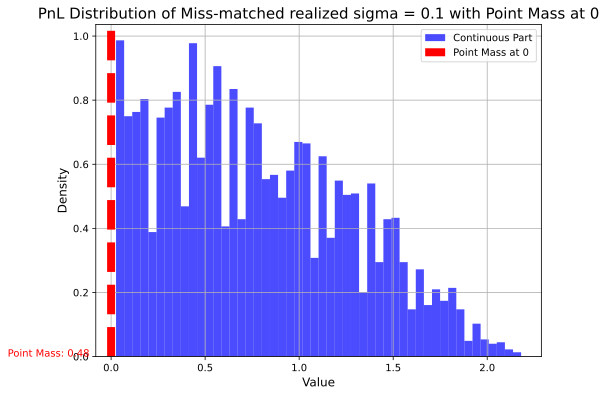

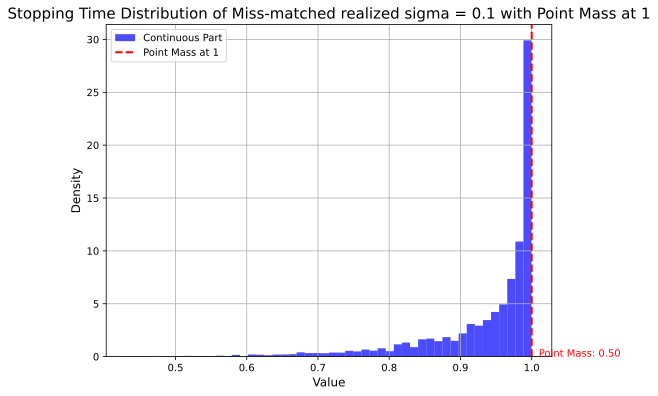

In [16]:
# iii)
# First we get the exercise boundary of the Put assuming sigma = 0.20
S0 = 10    # Initial stock price
K = 10     # Strike price
T = 1      # Time to maturity (1 year)
r = 0.02   # Risk-free rate
sigma = 0.20  # Volatility
mu = 0.05    # Expected return
N = 5000     # Number of steps

tree = BinomialModelAmericanPut(S0, K, T, r, sigma, mu, N)
early_exercise_js, exercise_boundary = tree.get_early_exercise_prices()

# Then we calculate the price paths for all possible realized volatilities
for sigma_new in [0.10]:#, 0.15, 0.20, 0.25, 0.30]:
    tree = BinomialModelAmericanPut(S0, K, T, r, sigma_new, mu, N)
    realized_exercise = tree.override_realized_exercise(exercise_boundary)
    sample_paths = tree.gen_simulation_paths(10000)
    PnL_distirbution = []
    stopping_time_distribution = []
    for path in sample_paths:
        PnL_early_exercise, stopping_time_early_exercise = tree.fetch_path_result(path)
        PnL_distirbution.append(PnL_early_exercise)
        stopping_time_distribution.append(stopping_time_early_exercise / tree.N)

    # Plot the PnL histogram
    PnL_continuous_part = [x for x in PnL_distirbution if x > 0]
    PnL_point_mass_count = len([x for x in PnL_distirbution if x == 0])
    plt.figure(figsize=(8, 6))
    plt.hist(PnL_continuous_part, bins=50, density=True, alpha=0.7, color='blue', label='Continuous Part')
    plt.axvline(x=0, color='red', linestyle='--', linewidth=8, label='Point Mass at 0')
    PnL_relative_mass_prob = PnL_point_mass_count / len(PnL_distirbution)
    plt.text(-0.55, 0., f'Point Mass: {PnL_relative_mass_prob:.2f}', color='red')
    plt.title(f"PnL Distribution of Miss-matched realized sigma = {sigma_new} with Point Mass at 0", fontsize=15)
    plt.xlabel("Value", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.legend()
    plt.grid(True)
    # plt.savefig(f'/content/drive/My Drive/SyncWorkspace/MMF/MMF1928H/Project 1/Miss-match-vol_PnL_distribution_plot-sigma={sigma_new}.jpg')

    # Separate the continuous part and the point mass part
    stopping_time_continuous_part = [x for x in stopping_time_distribution if x < 1]
    stopping_time_point_mass_count = len([x for x in stopping_time_distribution if x == 1])
    plt.figure(figsize=(8, 6))
    plt.hist(stopping_time_continuous_part, bins=50, density=True, alpha=0.7, color='blue', label='Continuous Part')
    plt.axvline(x=1, color='red', linestyle='--', linewidth=2, label='Point Mass at 1')
    stopping_time_relative_mass_prob = stopping_time_point_mass_count / len(stopping_time_distribution)
    plt.text(1+0.01, 0., f'Point Mass: {stopping_time_relative_mass_prob:.2f}', color='red')
    plt.title(f"Stopping Time Distribution of Miss-matched realized sigma = {sigma_new} with Point Mass at 1", fontsize=15)
    plt.xlabel("Value", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.legend()
    plt.grid(True)
    # plt.savefig(f'/content/drive/My Drive/SyncWorkspace/MMF/MMF1928H/Project 1/Miss-match-vol_Stopping_time_distribution_plot-sigma={sigma_new}.jpg')
